# Assignment 3: Cavity Blockade

In [128]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import qutip as qtp

from plots import *
from solving_methods import *

from scipy.special import factorial
from joblib import Parallel, delayed
from itertools import product

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Hamiltonian:

$H = \hbar \omega_c \mathbb{I}_a \otimes\hat{a}^\dag\hat{a} + \hbar \omega_a \ket{e}\bra{e} \otimes \mathbb{I}_c + \hbar \tilde{g}\left( \sigma^+ \hat{a} + \sigma^- \hat{a}^\dag\right) + (\mathcal{E}e^{i\omega t} \mathbb{I}\otimes\hat{a} +\text{h.c.}) \\$

After RWA ($\hbar = 1$):

$H = \delta_C a^\dag a + \delta_a \ket{e}\bra{e} + \tilde{g}(\sigma^+ a + \sigma_- a^\dag) + \mathcal{E}(a + a^\dag)$

### Decoupled dynamics: $\omega = \omega_a = \omega_c$ and $\tilde{g}=0$

Initial state $\ket{g, 0}$, small atom decay rate $\Gamma$ and small cavity dissipation rate $\kappa$

In [129]:
T0    = 0
Tf    = 1500
Nt    = Tf*50

OMEGA = 1   # Resonant frequency
N_ph  = 20  # Fock space dimension
E     = [0.015, 0.01, 0.005]  # Pumping field amplitude
GAMMA = 0.01 # Atom decay rate
KAPPA = 0.01 # Cavity dissipation rate

psi0    = qtp.tensor(qtp.basis(2,1), qtp.fock(N_ph, 0)) # Initial state
results_g0 = solve_JC_LME_parallelized(psi0, 0, 0, 0, E, [KAPPA], [GAMMA], N_ph, T0, Tf, Nt)

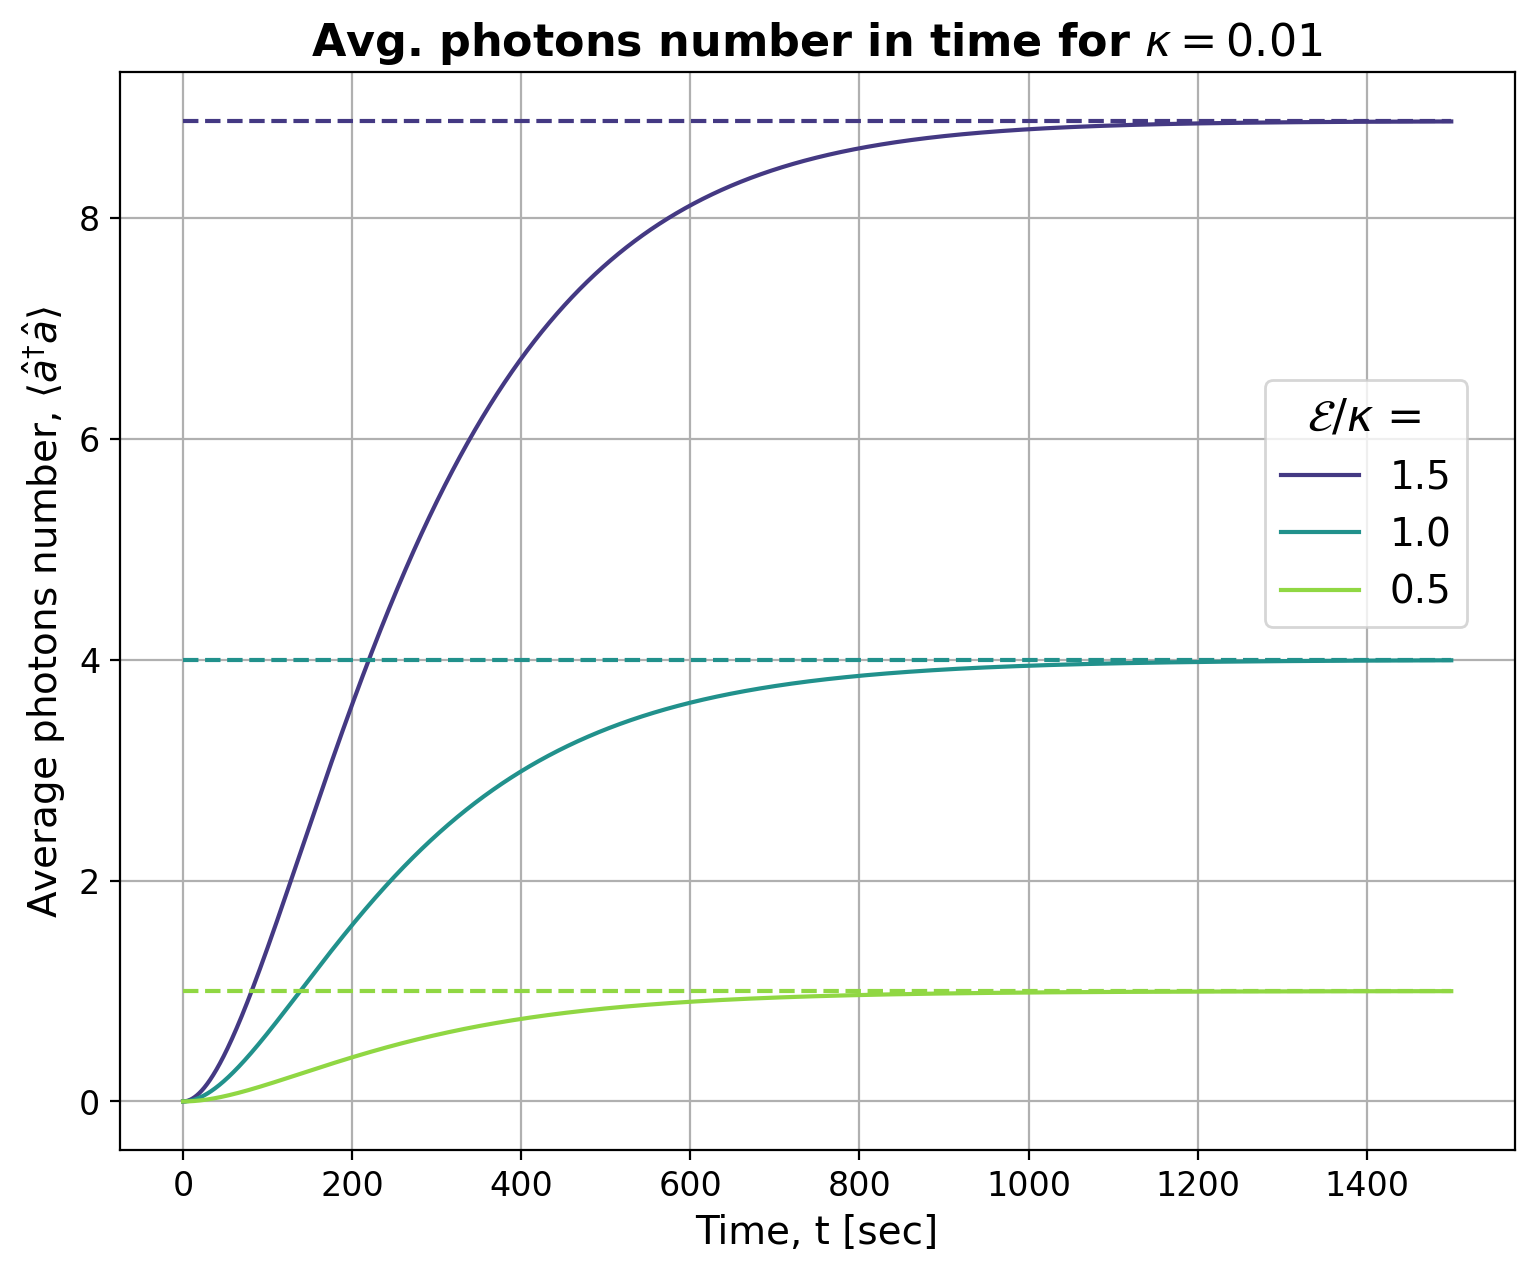

In [130]:
plot_mean_values(results_g0, T0, Tf, Nt, GAMMA, title=rf"Avg. photons number in time for $\kappa={KAPPA}$")

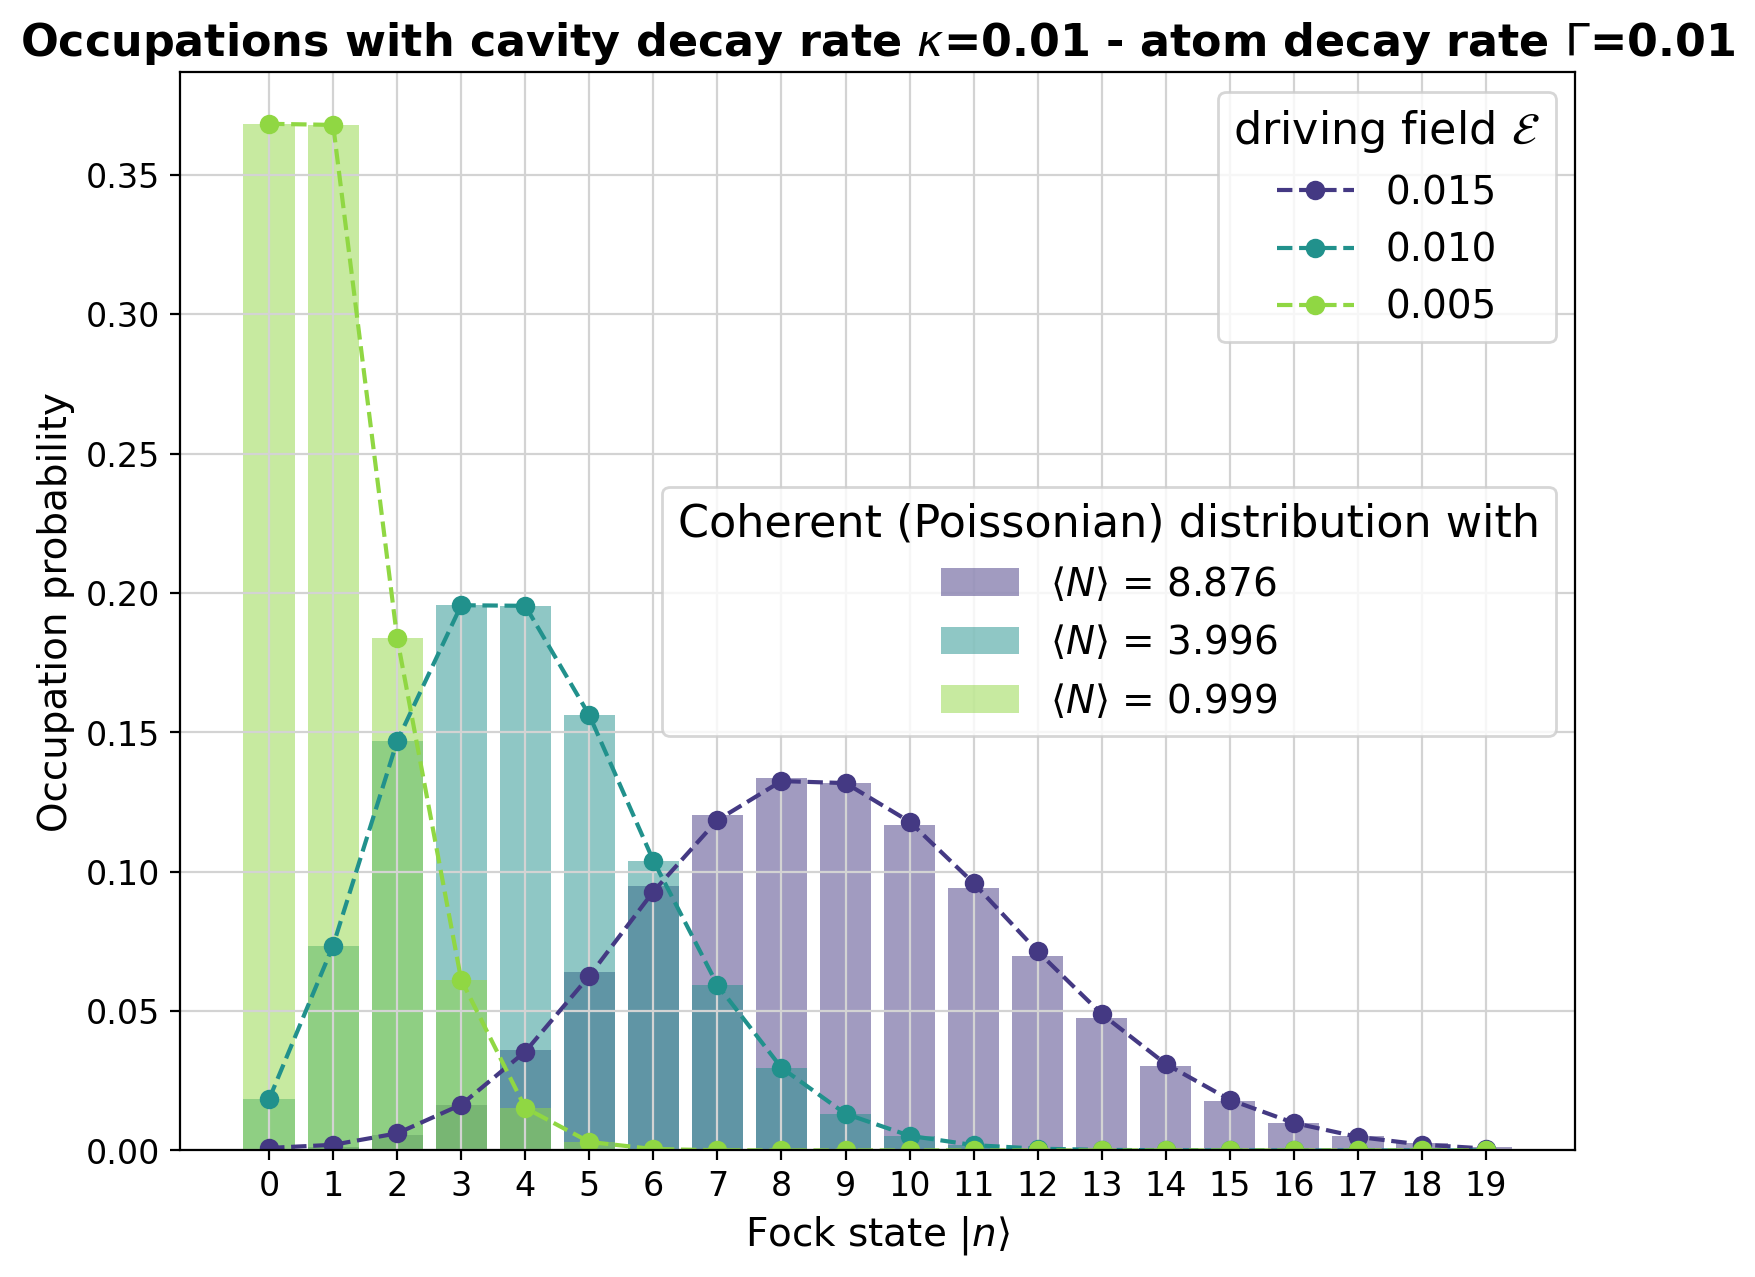

In [131]:
param_list = [
    r"driving field $\mathcal{E}$",
    r"cavity decay rate $\kappa$",
    r"atom decay rate $\Gamma$"
]

plot_occupations(results_g0, 0, param_list, True, prefix_title="Occupations with ")

### Coupled dynamics: $\tilde{g} \neq 0$, $\omega = \omega_c - \tilde{g}, \, \tilde{g} >> \kappa >> \mathcal{E}$

In [132]:
g_til = 0.5
GAMMA = 0.01
KAPPA = 0.01
omega_c = 5 # We assume it is the same as the atom for simplicity (omega_c = omega_a)
omega   = omega_c - g_til
E = [10**-3 * k for k in range(1, 6)]

T0    = 0
Tf    = 1000
Nt    = Tf*50
times = np.linspace(T0, Tf, Nt)
N_ph = 4

psi0 = qtp.tensor(qtp.basis(2,1), qtp.fock(N_ph, 0)) # Initial state
results_g = solve_JC_LME_parallelized(psi0, omega_c-omega, omega_c-omega, g_til, E, [KAPPA], [GAMMA], N_ph, T0, Tf, Nt)

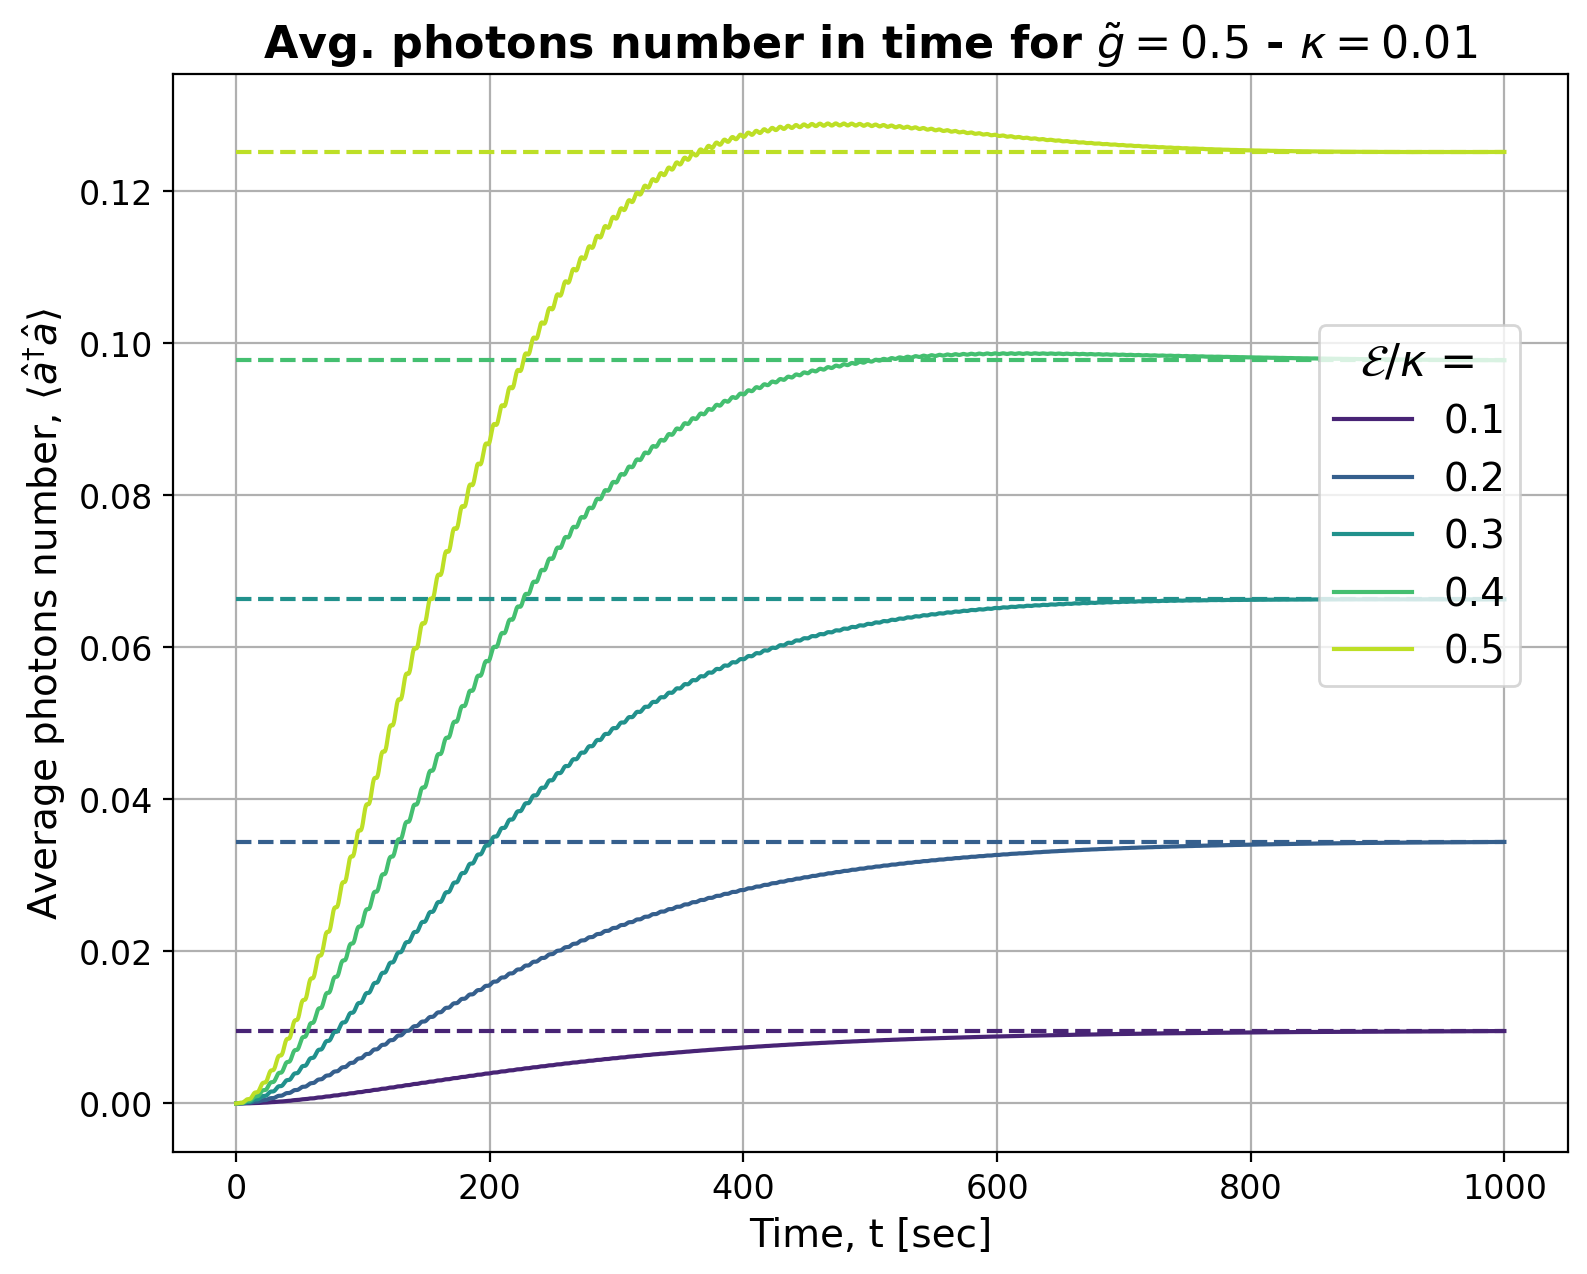

In [9]:
plot_mean_values(results_g, T0, Tf, Nt, GAMMA, title=fr"Avg. photons number in time for $\tilde g={g_til}$ - $\kappa = {KAPPA}$")

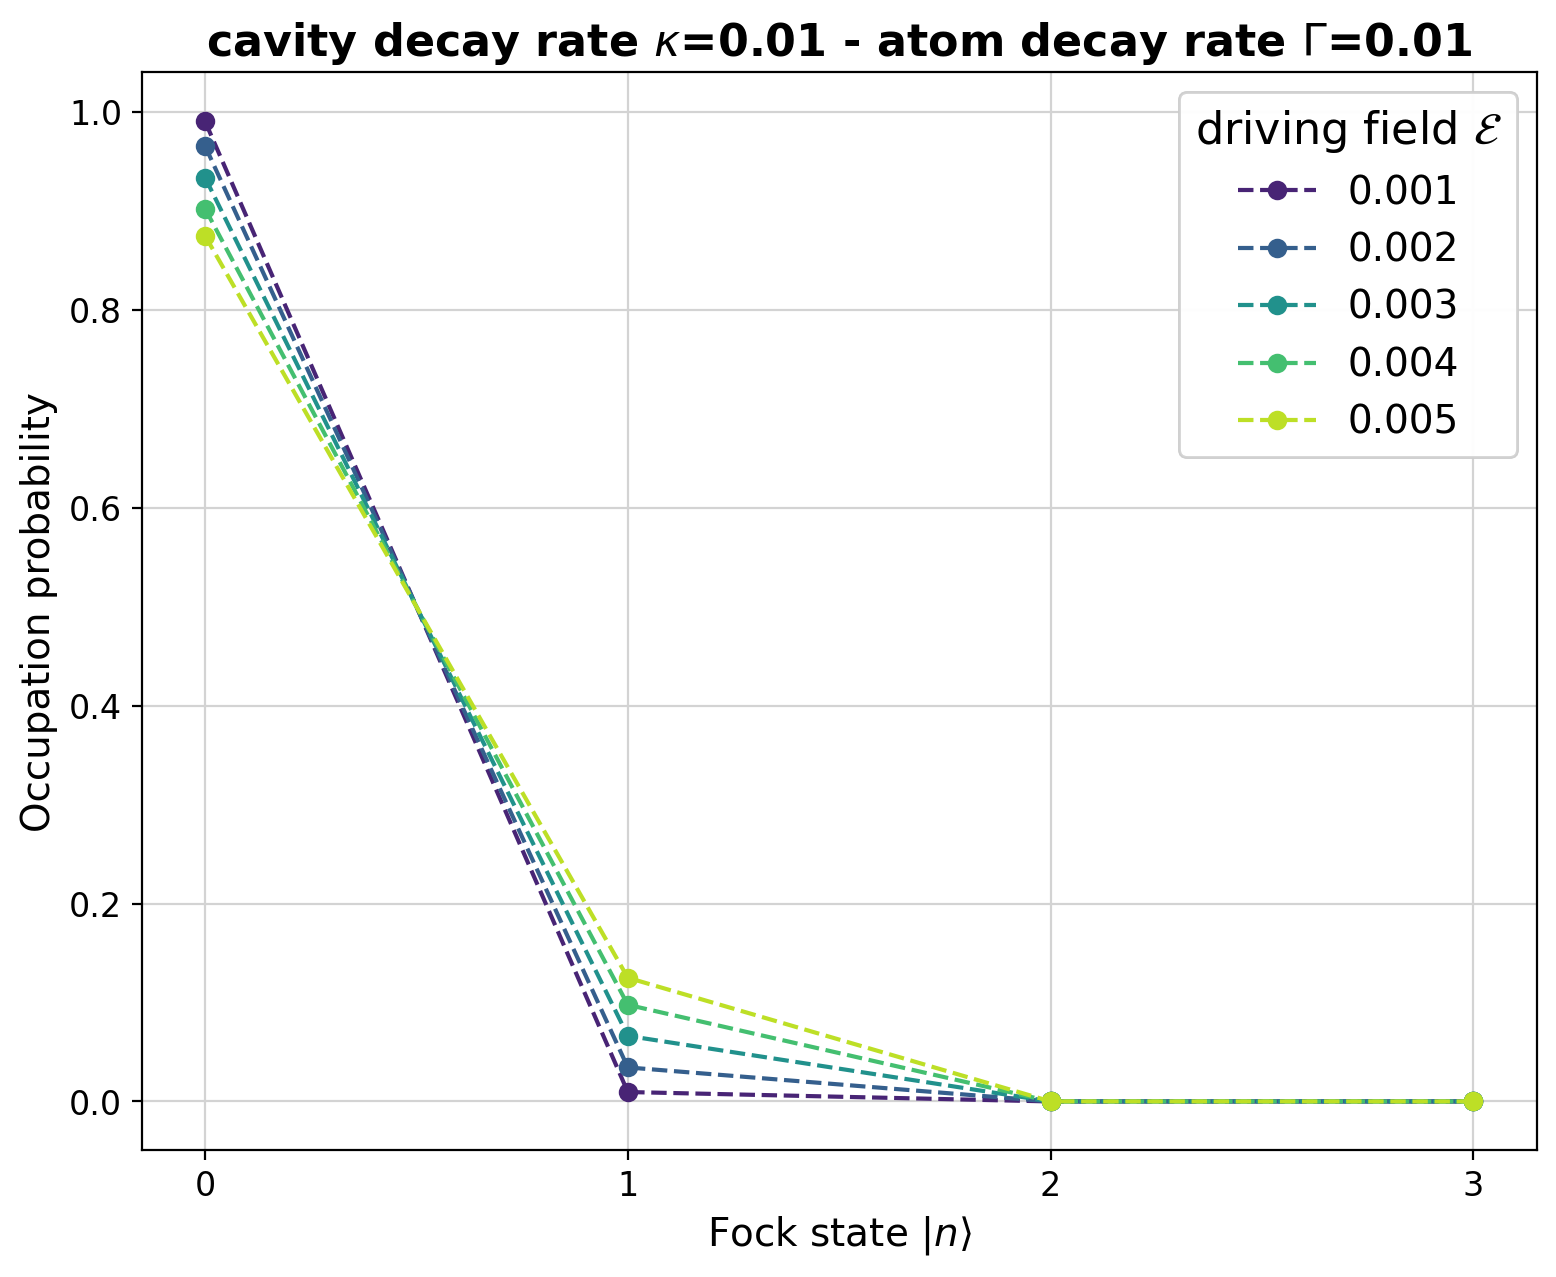

In [133]:
plot_occupations(results_g, 0, param_list, False)

### Changing decay rates

In [202]:
E = 0.001
g_til = 0.5
KAPPA_L = [0.0001 * k**2 for k in range(0, 12, 2)]  # range tra 0.0001 e 0.01
KAPPA_L[0] = 0.0001
GAMMA_L = KAPPA_L
results = solve_JC_LME_parallelized(
    psi0, omega_c-omega, omega_c-omega, g_til, [E], KAPPA_L, GAMMA_L, N_ph, T0, Tf, Nt, return_type="arr"
)

In [194]:
results.shape

(36,)

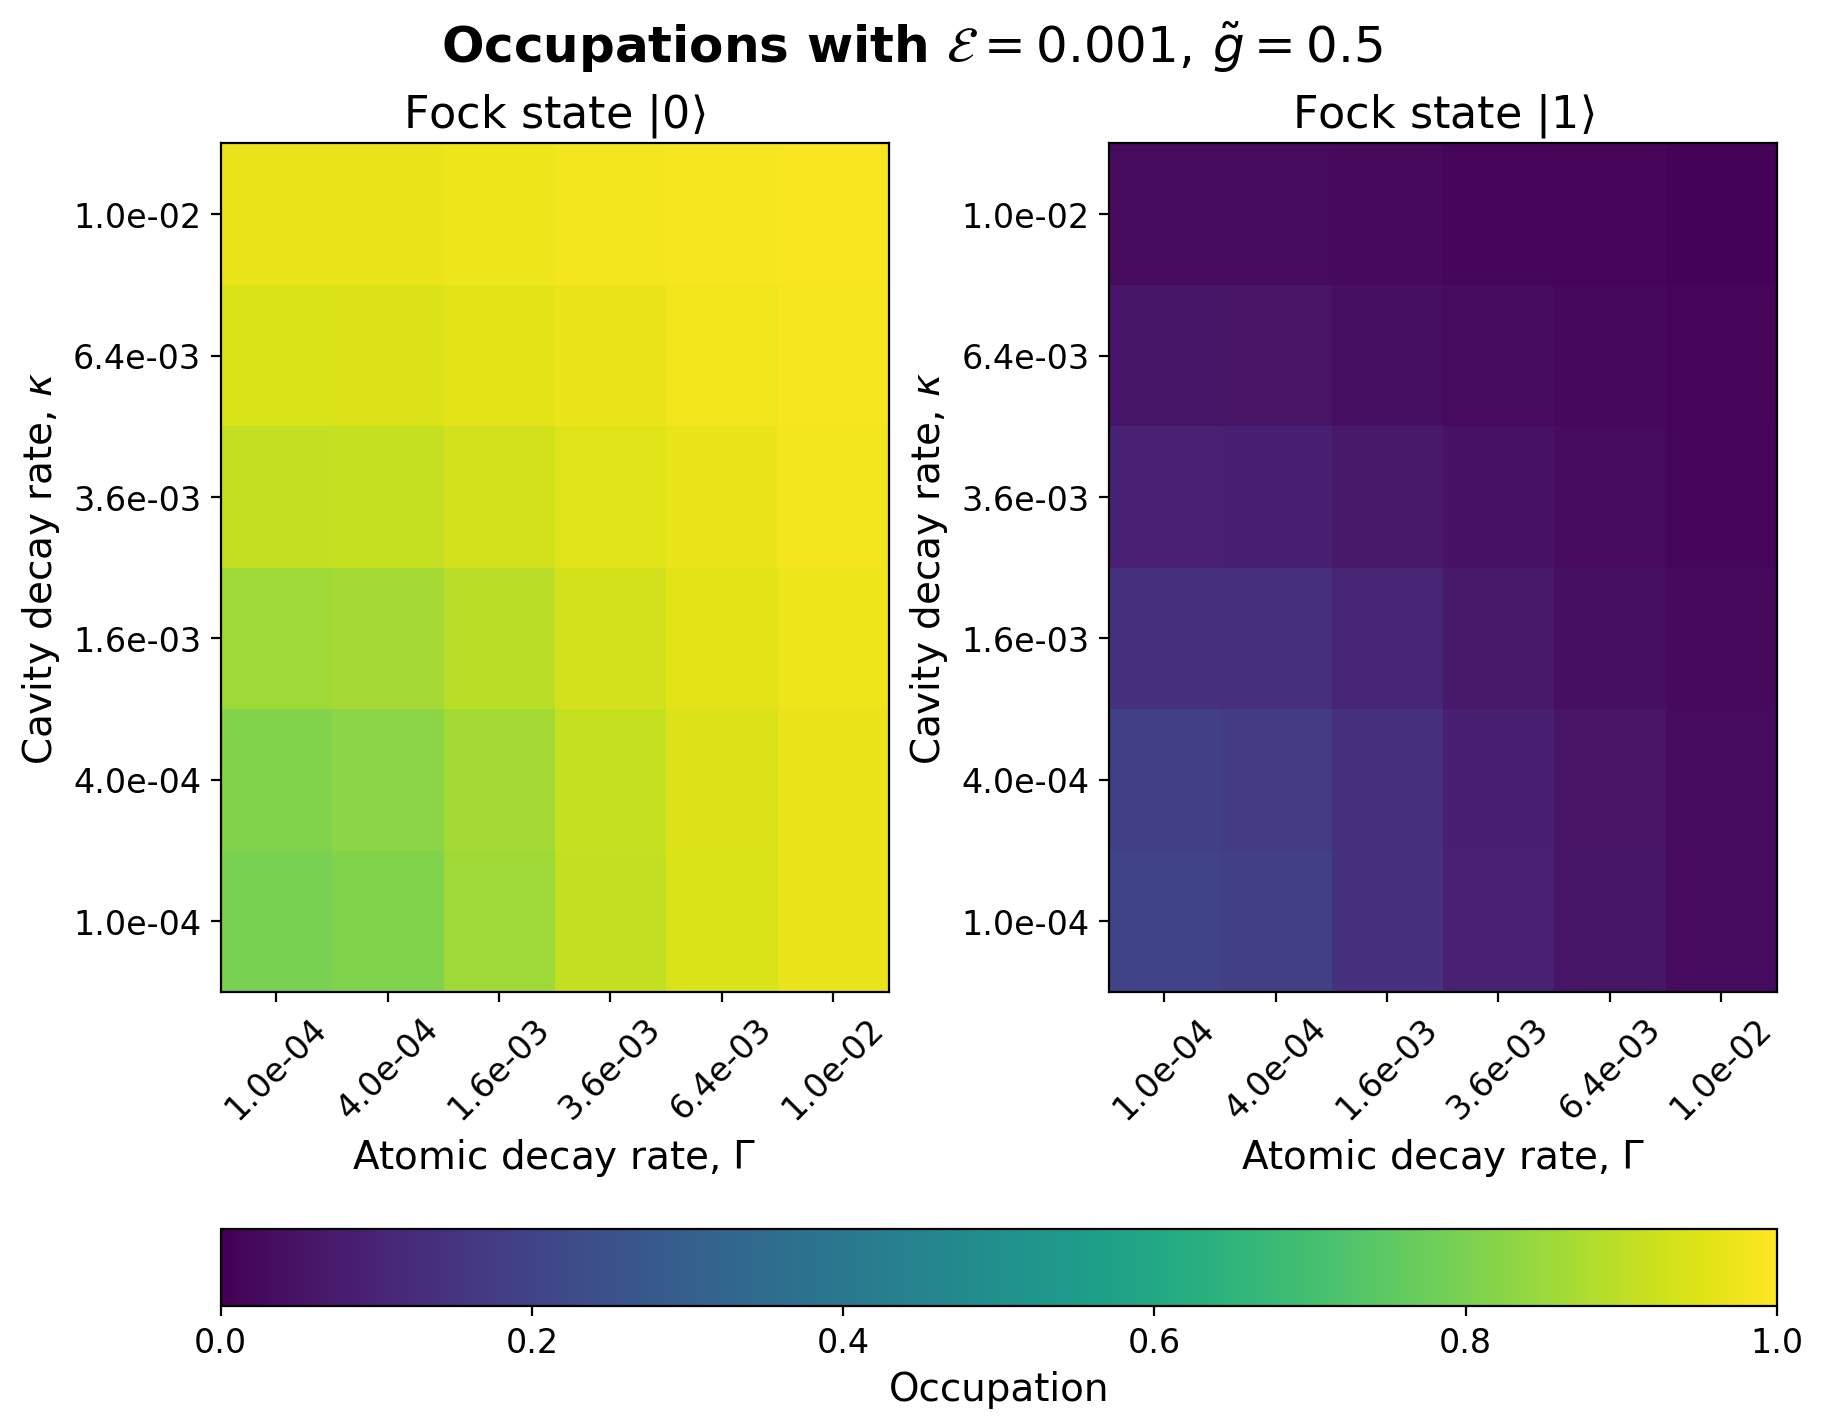

In [213]:
plot_heatmap_occupations(results, 1, GAMMA_L, KAPPA_L, rf"Occupations with $\mathcal{{E}}={E}, \, \tilde g = {g_til}$")

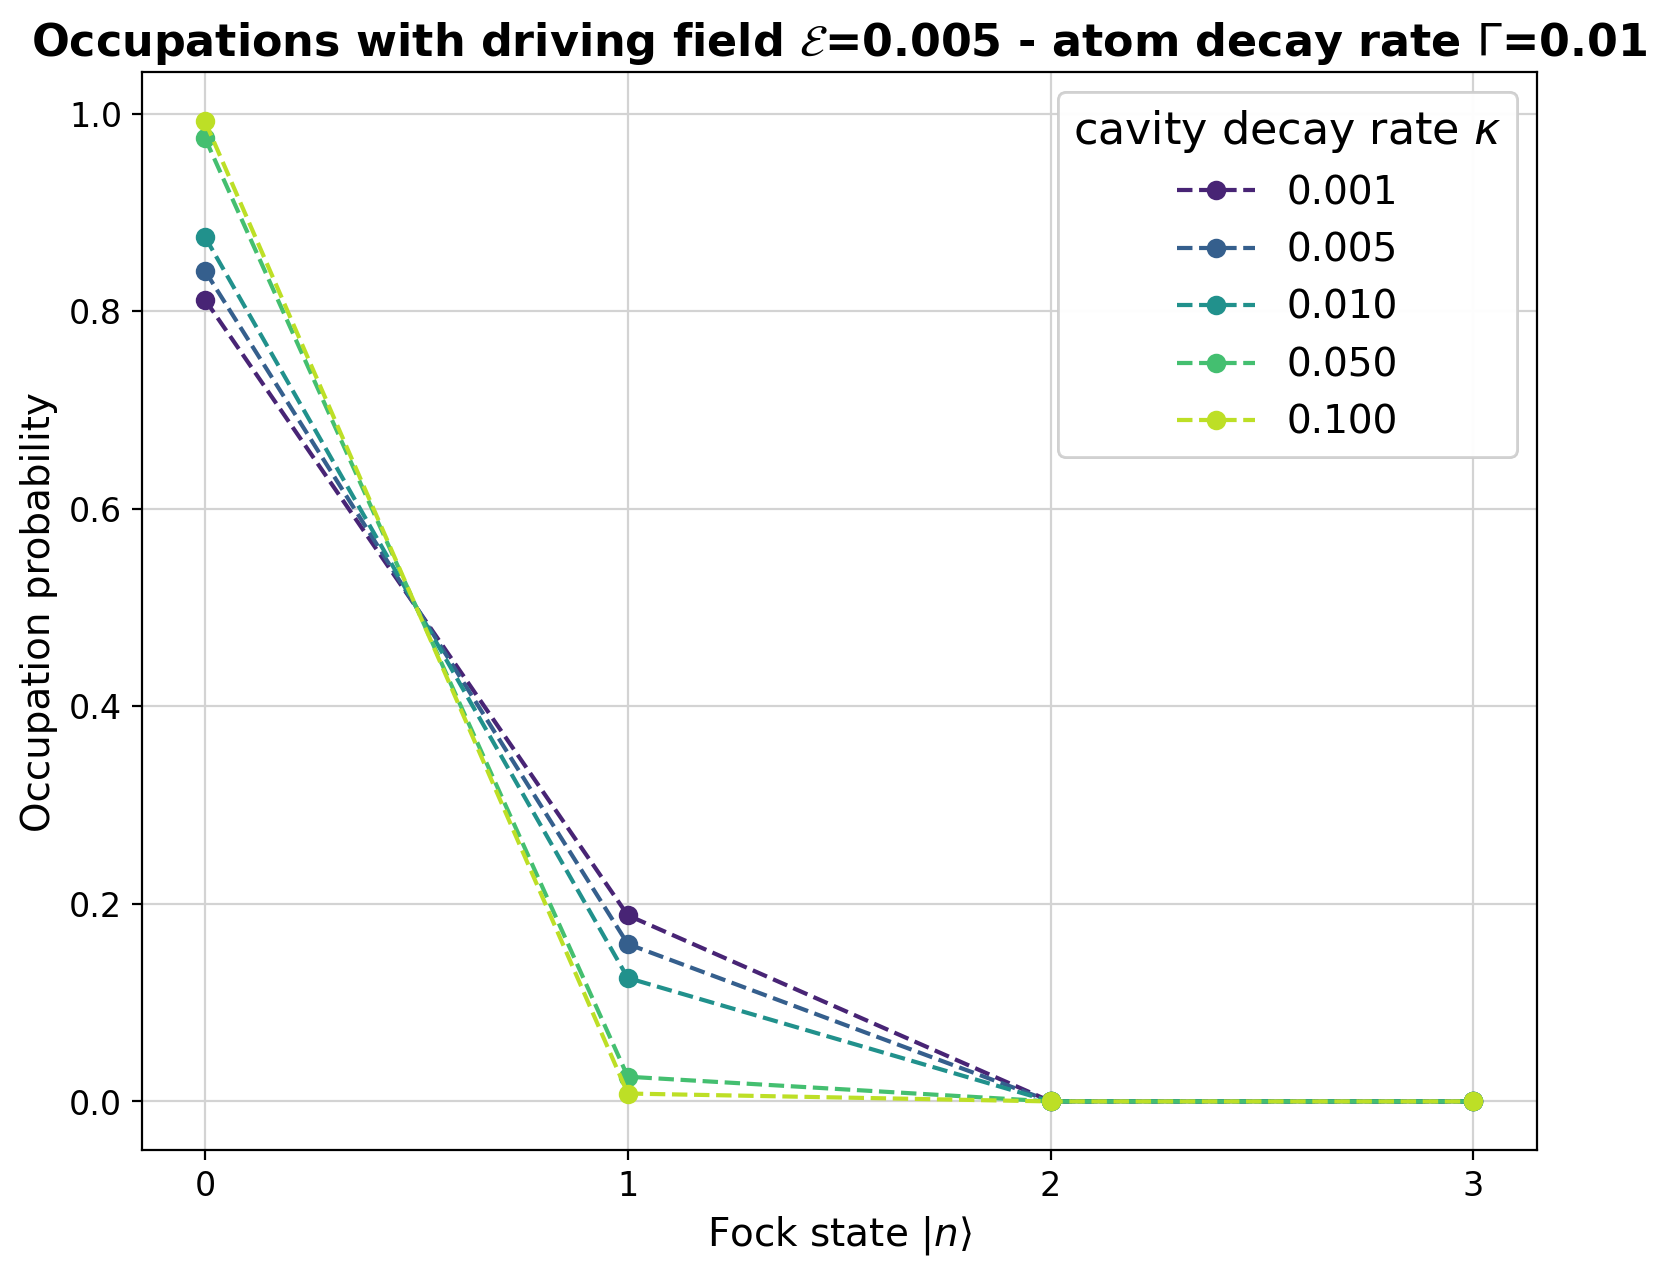

In [38]:
param_list = [
    r"driving field $\mathcal{E}$",
    r"cavity decay rate $\kappa$",
    r"atom decay rate $\Gamma$"
]
plot_occupations(results, 1, param_list, prefix_title="Occupations with ")

### Changing coupling $\tilde{g}$

In [39]:
g_til_L = [2**-k for k in range(0, 8)]
E = 0.005
results = solve_JC_LME_resonance(
    psi0, omega_c, omega_c, g_til_L, E, KAPPA, GAMMA, N_ph, T0, Tf, Nt
)

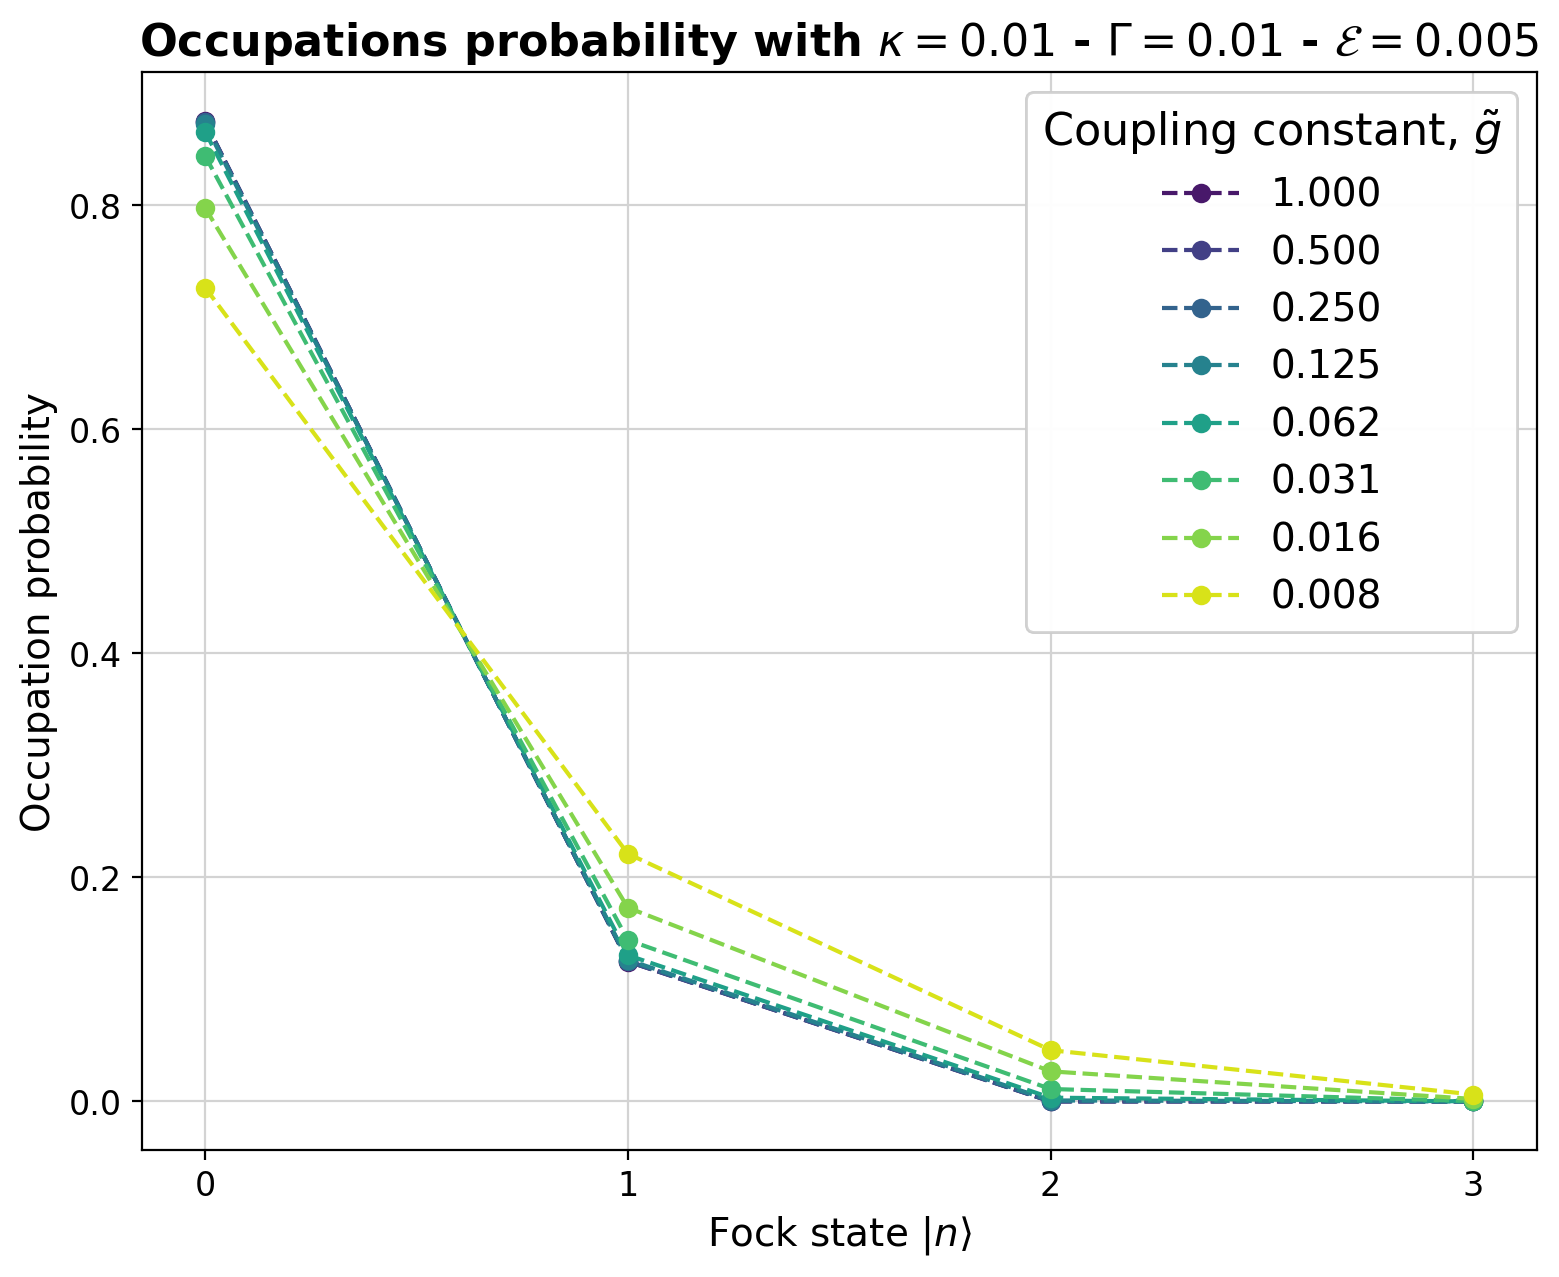

In [40]:
param_list = [
    r"Driving frequency, $\omega$",
    r"Coupling constant, $\tilde{g}$"
]
# RIMUOVERE TITOLO
plot_occupations(results, 1, param_list, full_title=rf"Occupations probability with $\kappa={KAPPA}$ - $\Gamma={GAMMA}$ - $\mathcal{{E}}={E}$") 

### Scanning around $\omega_d = \omega_{resonance}$ (strong coupling, weak drive)

In [77]:
g_til = 0.5
GAMMA = 0.01
KAPPA = 0.01
omega_c = 5 # We assume it is the same as the atom for simplicity (omega_c = omega_a)
omega_res = omega_c - g_til
omega_L   = list(np.linspace(omega_c-g_til*1.5, omega_c+g_til*1.5, 100))
E = 0.005

T0    = 0
Tf    = 1000
Nt    = Tf*50
N_ph = 4

psi0 = qtp.tensor(qtp.basis(2,1), qtp.fock(N_ph, 0)) # Initial state
scan_results = solve_JC_LME_scan_omega(psi0, omega_L, omega_c, omega_c, g_til, E, KAPPA, GAMMA, N_ph, T0, Tf, Nt)

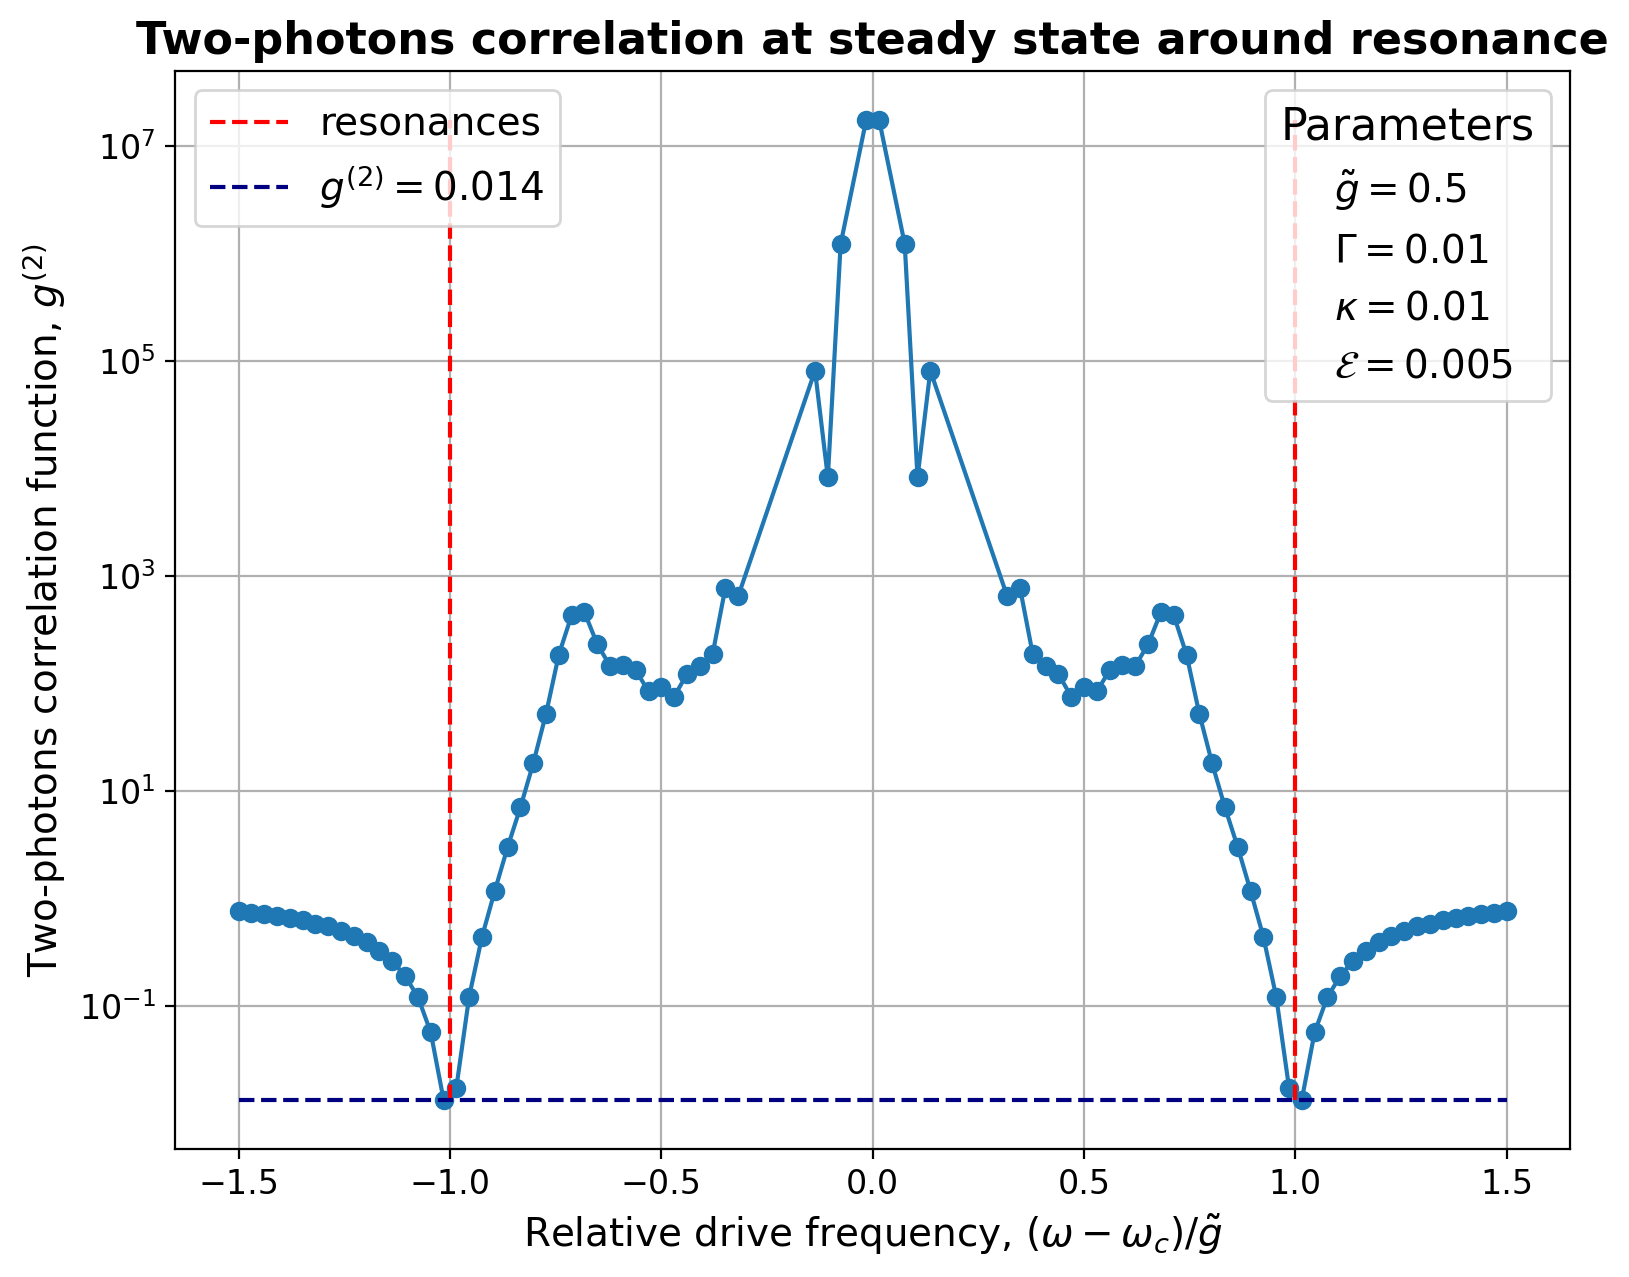

In [87]:
plot_two_photons_corr(scan_results, omega_c, g_til, GAMMA, KAPPA, E)